Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

📌 PASO 11: Evaluación del modelo funcional con matriz de distancias
📊 Muestra: 100% | k = 15 | λ = 1.9915
🧮 Top 3 variables con mayor peso: RAO, RCC, ROI


🔁 Folds validación:   0%|          | 0/10 [00:00<?, ?it/s]

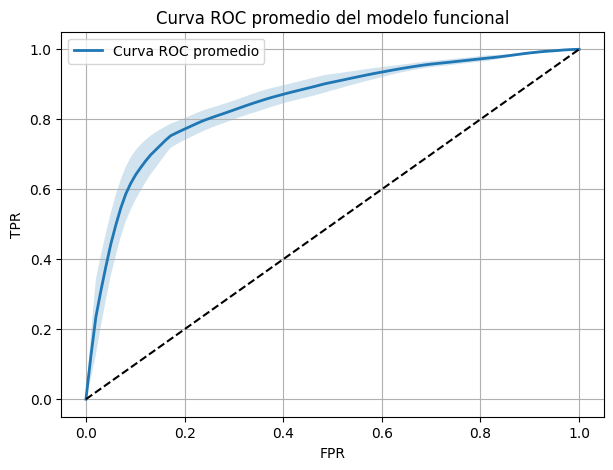

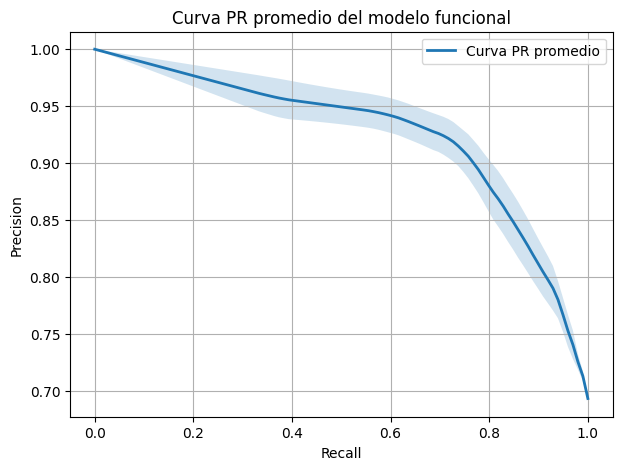

,Accuracy,Precision,Recall,F1-score,AUC,Log Loss,k,lambda,Top 1 variable,Top 2 variable,Top 3 variable,Observación
0,0.7682 ±0.0136,0.7723 ±0.0119,0.9446 ±0.0125,0.8497 ±0.0081,0.8474 ±0.0220,0.8210 ±0.1664,15,1.991533,"RAO (peso bruto: 4.964, normalizado: 11.1%)","RCC (peso bruto: 4.868, normalizado: 10.8%)","ROI (peso bruto: 4.766, normalizado: 10.6%)",Desempeño moderado. Variabilidad moderada.


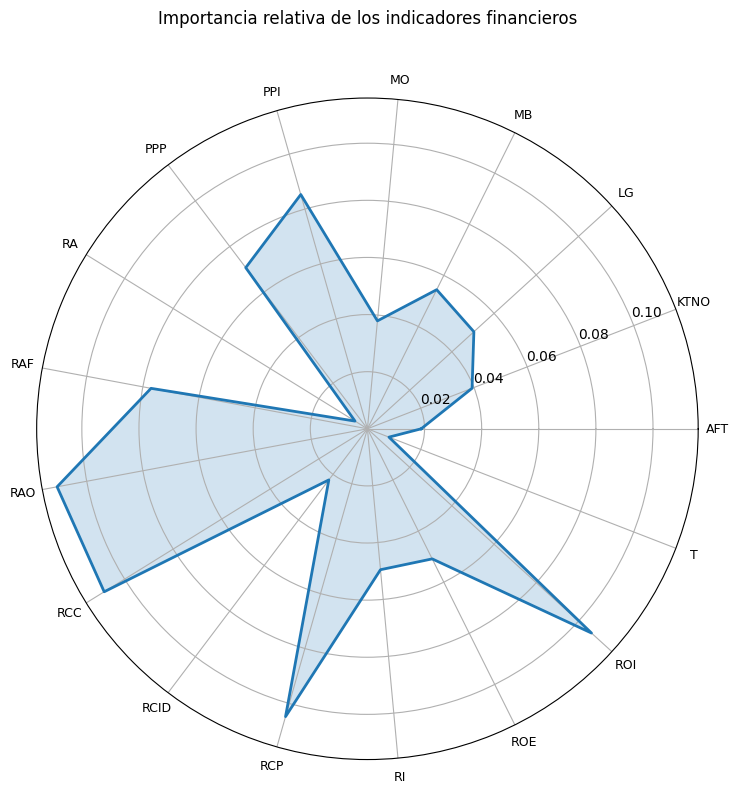

🔍 Prediciendo empresas con matriz:   0%|          | 0/5565 [00:00<?, ?it/s]

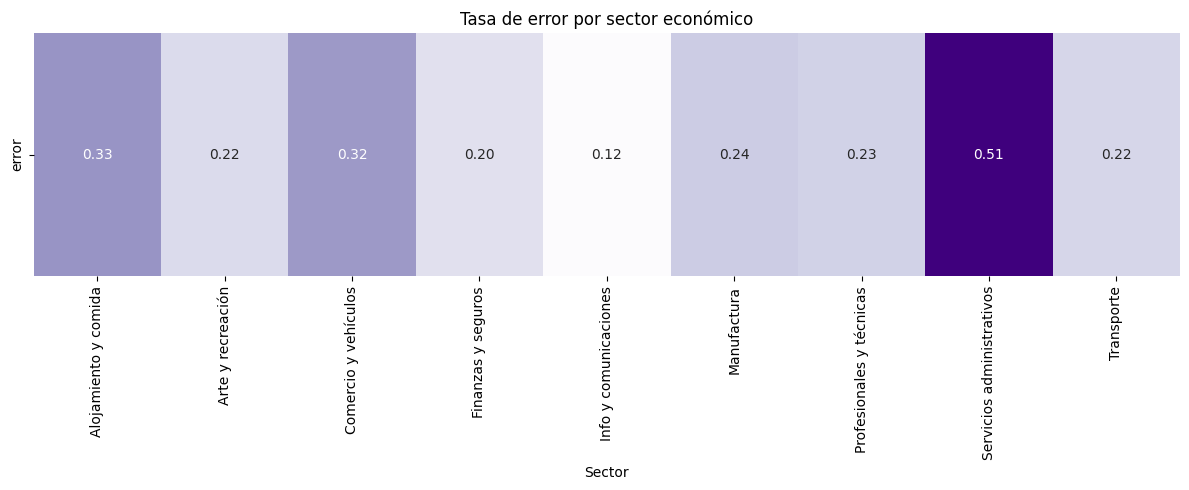

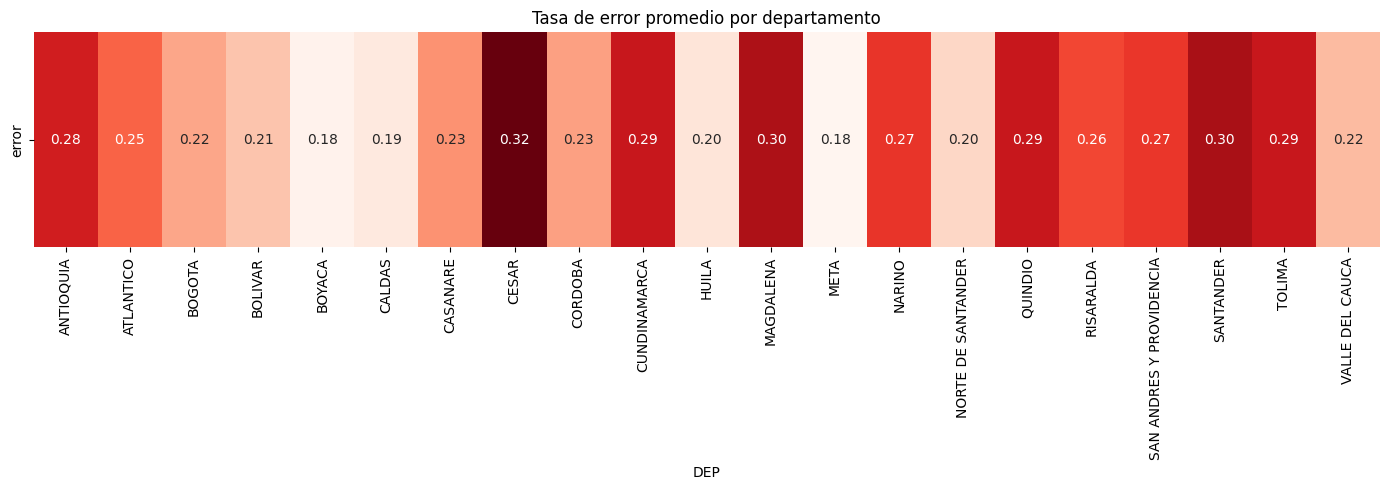

🔢 Empresas por sector (>=50):
CIIU_Letra
H    1417
I    1206
J     964
R     948
M     440
C     125
N     123
G     123
K     100
Name: count, dtype: int64

🔢 Empresas por departamento (>=20):
DEP
BOGOTA                      2783
ANTIOQUIA                    675
VALLE DEL CAUCA              532
ATLANTICO                    289
BOLIVAR                      198
SANTANDER                    187
CUNDINAMARCA                 140
RISARALDA                     76
CALDAS                        73
MAGDALENA                     64
NORTE DE SANTANDER            59
TOLIMA                        56
META                          55
SAN ANDRES Y PROVIDENCIA      52
CORDOBA                       44
QUINDIO                       42
HUILA                         41
BOYACA                        38
NARINO                        37
CASANARE                      30
CESAR                         22
Name: count, dtype: int64
📝 Resumen .tex guardado en: /content/drive/MyDrive/Resultados/11_6_Resumen.tex


In [3]:
# PASO 11: Evaluación completa del modelo funcional
# ==================================================

# 🚗 Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📚 Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, log_loss,
    precision_recall_curve, average_precision_score
)
import os

# 📍 Rutas
ruta_base = "/content/drive/MyDrive/Datos/9_1EspacioF.parquet"
ruta_parametros = "/content/drive/MyDrive/Datos/9_2ParametrosFuncional.pkl"
ruta_matriz = "/content/drive/MyDrive/Datos/10_Matriz_Distancias_Funcional.npy"
ruta_nits = "/content/drive/MyDrive/Datos/10_Orden_NITs_Funcional.npy"

# 📍 Rutas de salida
ruta_resultados = "/content/drive/MyDrive/Resultados/11_1_Resultados_Modelo_Funcional.pkl"
ruta_roc = "/content/drive/MyDrive/Resultados/11_2_ROC_Folds.pkl"
ruta_prc = "/content/drive/MyDrive/Resultados/11_3_PRC_Folds.pkl"
ruta_radar = "/content/drive/MyDrive/Resultados/11_4_Radar_Pesos_Indicadores.png"
ruta_predicciones = "/content/drive/MyDrive/Resultados/11_5_Errores_Por_Empresa_Funcional.parquet"
ruta_sector = "/content/drive/MyDrive/Resultados/11_7_Heatmap_Errores_CIIU_Nombres.png"
ruta_departamento = "/content/drive/MyDrive/Resultados/11_8_Heatmap_Errores_Departamentos.png"

# 💾 Cargar datos y parámetros
df = pd.read_parquet(ruta_base)
with open(ruta_parametros, "rb") as f:
    parametros = pickle.load(f)
matriz_dist = np.load(ruta_matriz)
nits_orden = np.load(ruta_nits, allow_pickle=True)

# 🧮 Extraer parámetros
k_final = parametros["k"]
lambda_final = parametros["lambda"]
pesos_finales = parametros["pesos"]
top3_final = parametros["top3"]
n_ventana = 5
suma_pesos = sum(pesos_finales.values())
pesos_normalizados = {var: peso / suma_pesos for var, peso in pesos_finales.items()}
indicadores = sorted(pesos_normalizados.keys())

# 🎯 Asegurar orden de empresas
df = df[df["RQ_final"].notna()].copy()
if "NIT" in df.columns:
    df = df.set_index("NIT", drop=False)
df = df.loc[nits_orden]
y = df["RQ_final"].values
NITs = df.index.tolist()

# 🔁 Validación cruzada
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracy_list, precision_list, recall_list, f1_list, auc_list, logloss_list = [], [], [], [], [], []
roc_data, prc_data, avg_precisions = [], [], []

print(f"\n📌 PASO 11: Evaluación del modelo funcional con matriz de distancias")
print(f"📊 Muestra: 100% | k = {k_final} | λ = {lambda_final:.4f}")
print(f"🧮 Top 3 variables con mayor peso: {', '.join([v[0] for v in top3_final])}")

for fold, (train_idx, test_idx) in enumerate(tqdm(skf.split(matriz_dist, y), total=10, desc="🔁 Folds validación")):
    y_train, y_test = y[train_idx], y[test_idx]

    preds, probs = [], []
    for i in test_idx:
        distancias = [(matriz_dist[i, j], y[j]) for j in train_idx]
        vecinos = sorted(distancias, key=lambda x: x[0])[:k_final]
        proba = np.mean([v[1] for v in vecinos])
        preds.append(round(proba))
        probs.append(proba)

    accuracy_list.append(accuracy_score(y_test, preds))
    precision_list.append(precision_score(y_test, preds, zero_division=0))
    recall_list.append(recall_score(y_test, preds))
    f1_list.append(f1_score(y_test, preds))
    auc_list.append(roc_auc_score(y_test, probs))
    logloss_list.append(log_loss(y_test, probs))

    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_data.append({"fold": fold+1, "fpr": fpr, "tpr": tpr})

    precision, recall, _ = precision_recall_curve(y_test, probs)
    avg_precisions.append(average_precision_score(y_test, probs))
    prc_data.append({"fold": fold+1, "precision": precision, "recall": recall})

# 📈 Curva ROC promedio
mean_fpr = np.linspace(0, 1, 100)
tprs = [np.interp(mean_fpr, r["fpr"], r["tpr"]) for r in roc_data]
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_tpr[-1] = 1.0

plt.figure(figsize=(7, 5))
plt.plot(mean_fpr, mean_tpr, label='Curva ROC promedio', linewidth=2)
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, alpha=0.2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC promedio del modelo funcional")
plt.grid(True)
plt.legend()
plt.show()

# 📉 Curva PR promedio
mean_recall = np.linspace(0, 1, 100)
precisions_interp = [np.interp(mean_recall, r["recall"][::-1], r["precision"][::-1]) for r in prc_data]
mean_precision = np.mean(precisions_interp, axis=0)
std_precision = np.std(precisions_interp, axis=0)

plt.figure(figsize=(7, 5))
plt.plot(mean_recall, mean_precision, label='Curva PR promedio', linewidth=2)
plt.fill_between(mean_recall, mean_precision - std_precision, mean_precision + std_precision, alpha=0.2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva PR promedio del modelo funcional")
plt.grid(True)
plt.legend()
plt.show()

# 📋 Resumen final
f1_mean = np.mean(f1_list)
f1_std = np.std(f1_list)
desempeno = "Muy alto / excelente desempeño" if f1_mean >= 0.95 else \
            "Alto desempeño" if f1_mean >= 0.85 else \
            "Desempeño moderado" if f1_mean >= 0.70 else \
            "Bajo desempeño" if f1_mean >= 0.50 else "Muy bajo desempeño"
robustez = "Altamente robusto y estable" if f1_std <= 0.0003 else \
           "Muy estable" if f1_std <= 0.002 else \
           "Buena estabilidad" if f1_std <= 0.007 else \
           "Variabilidad moderada" if f1_std <= 0.015 else "Alta variabilidad / menos robusto"
observacion = f"{desempeno}. {robustez}."

top3_bruto_normalizado = [
    f"{var} (peso bruto: {peso_bruto:.3f}, normalizado: {pesos_normalizados[var]*100:.1f}%)"
    for var, peso_bruto in top3_final
]

resumen_final = {
    "Accuracy": f"{np.mean(accuracy_list):.4f} ±{np.std(accuracy_list):.4f}",
    "Precision": f"{np.mean(precision_list):.4f} ±{np.std(precision_list):.4f}",
    "Recall": f"{np.mean(recall_list):.4f} ±{np.std(recall_list):.4f}",
    "F1-score": f"{f1_mean:.4f} ±{f1_std:.4f}",
    "AUC": f"{np.mean(auc_list):.4f} ±{np.std(auc_list):.4f}",
    "Log Loss": f"{np.mean(logloss_list):.4f} ±{np.std(logloss_list):.4f}",
    "k": k_final,
    "lambda": lambda_final,
    "Top 1 variable": top3_bruto_normalizado[0],
    "Top 2 variable": top3_bruto_normalizado[1],
    "Top 3 variable": top3_bruto_normalizado[2],
    "Observación": observacion
}

display(pd.DataFrame([resumen_final]))

# 💾 Guardar resultados
os.makedirs("/content/drive/MyDrive/Resultados", exist_ok=True)
with open(ruta_resultados, "wb") as f:
    pickle.dump({
        "resumen": resumen_final,
        "folds_accuracy": accuracy_list,
        "folds_precision": precision_list,
        "folds_recall": recall_list,
        "folds_f1": f1_list,
        "folds_auc": auc_list,
        "folds_logloss": logloss_list,
        "folds_avg_precision": avg_precisions,
        "params": {"k": k_final, "lambda": lambda_final, "pesos": pesos_finales, "top3": top3_final},
        "nits": NITs
    }, f)
with open(ruta_roc, "wb") as f:
    pickle.dump(roc_data, f)
with open(ruta_prc, "wb") as f:
    pickle.dump(prc_data, f)

# 🕸️ Gráfico radar de importancia de variables
variables = list(pesos_normalizados.keys())
valores = [pesos_normalizados[v] for v in variables]
valores_cerrado = valores + [valores[0]]
angles = np.linspace(0, 2 * np.pi, len(variables), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, valores_cerrado, linewidth=2)
ax.fill(angles, valores_cerrado, alpha=0.2)
ax.set_thetagrids(np.degrees(angles[:-1]), variables, fontsize=9)
ax.set_title("Importancia relativa de los indicadores financieros", y=1.1)
plt.tight_layout()
plt.savefig(ruta_radar)
plt.show()

# 📦 Cargar espacio funcional, parámetros y matriz
df_pred = pd.read_parquet(ruta_base)  # Este es 9_1EspacioF.parquet
matriz_dist = np.load(ruta_matriz)
nits_orden = np.load(ruta_nits, allow_pickle=True)

# 🧽 Filtrar empresas con RQ_final válido y alinear con matriz
df_pred = df_pred[df_pred["RQ_final"].notna()].copy()
if "NIT" in df_pred.columns:
    df_pred = df_pred.set_index("NIT", drop=False)
df_pred = df_pred.loc[nits_orden]  # asegurar orden idéntico a la matriz
y_real = df_pred["RQ_final"].values
NITs = df_pred.index.tolist()

# 🤖 Predicción usando la matriz de distancias
preds = []
for i in tqdm(range(len(y_real)), desc="🔍 Prediciendo empresas con matriz"):
    distancias = [(matriz_dist[i, j], y_real[j]) for j in range(len(y_real)) if j != i]
    vecinos = sorted(distancias, key=lambda x: x[0])[:k_final]
    proba = np.mean([v[1] for v in vecinos])
    pred = round(proba)
    preds.append(pred)

# 📋 Guardar predicciones y errores
df_pred["pred_RQ"] = preds
df_pred["error"] = df_pred["pred_RQ"] != df_pred["RQ_final"]
df_pred.to_parquet(ruta_predicciones, index=False)

# 🗺️ Mapas de calor
mapeo_sectores = {
    'A': 'Agro', 'B': 'Minería', 'C': 'Manufactura', 'D': 'Electricidad',
    'E': 'Agua y residuos', 'F': 'Construcción', 'G': 'Comercio y vehículos',
    'H': 'Transporte', 'I': 'Alojamiento y comida', 'J': 'Info y comunicaciones',
    'K': 'Finanzas y seguros', 'L': 'Inmobiliarias', 'M': 'Profesionales y técnicas',
    'N': 'Servicios administrativos', 'O': 'Gobierno', 'P': 'Educación',
    'Q': 'Salud y asistencia', 'R': 'Arte y recreación', 'S': 'Otros servicios',
    'T': 'Hogares empleadores', 'U': 'Organizaciones externas', np.nan: 'Sin clasificación'
}

conteo_ciiu = df_pred["CIIU_Letra"].value_counts()
letras_validas = conteo_ciiu[conteo_ciiu >= 50].index.tolist()
df_pred["Sector"] = df_pred["CIIU_Letra"].map(mapeo_sectores)
errores_sector = df_pred[df_pred["CIIU_Letra"].isin(letras_validas)].groupby("Sector")["error"].mean()

plt.figure(figsize=(12, 5))
sns.heatmap(errores_sector.to_frame().T, cmap="Purples", annot=True, fmt=".2f", cbar=False)
plt.title("Tasa de error por sector económico")
plt.tight_layout()
plt.savefig(ruta_sector)
plt.show()

conteo_dep = df_pred["DEP"].value_counts()
departamentos_validos = conteo_dep[conteo_dep >= 20].index.tolist()
errores_dep = df_pred[df_pred["DEP"].isin(departamentos_validos)].groupby("DEP")["error"].mean()

plt.figure(figsize=(14, 5))
sns.heatmap(errores_dep.to_frame().T, cmap="Reds", annot=True, fmt=".2f", cbar=False)
plt.title("Tasa de error promedio por departamento")
plt.tight_layout()
plt.savefig(ruta_departamento)
plt.show()

# 🧾 Conteos
print("🔢 Empresas por sector (>=50):")
print(conteo_ciiu[letras_validas])
print("\n🔢 Empresas por departamento (>=20):")
print(conteo_dep[departamentos_validos])
# 📝 Guardar resumen en formato .tex
ruta_resumen_tex = "/content/drive/MyDrive/Resultados/11_6_Resumen.tex"
with open(ruta_resumen_tex, "w") as f:
    f.write(r"\section*{Paso 11: Evaluación del Modelo Funcional con Matriz de Distancias}" + "\n")
    f.write(r"\begin{itemize}" + "\n")
    f.write(f"  \item Se evaluó el modelo funcional con validación cruzada de 10 folds.\n")
    f.write(f"  \item F1-score promedio: {f1_mean:.4f} ± {f1_std:.4f}\n")
    f.write(f"  \item Observación: {observacion}\n")
    f.write(f"  \item Top 3 variables con mayor peso:\n")
    f.write(r"  \begin{itemize}" + "\n")
    for v in top3_bruto_normalizado:
        f.write(f"    \item {v}\n")
    f.write(r"  \end{itemize}" + "\n")
    f.write(f"  \item Se utilizó la matriz de distancias funcionales previamente calculada.\n")
    f.write(f"  \item Se generaron los siguientes productos:\n")
    f.write(r"  \begin{itemize}" + "\n")
    f.write(r"    \item \texttt{11\_1\_Resultados\_Modelo\_Funcional.pkl}" + "\n")
    f.write(r"    \item \texttt{11\_2\_ROC\_Folds.pkl}" + "\n")
    f.write(r"    \item \texttt{11\_3\_PRC\_Folds.pkl}" + "\n")
    f.write(r"    \item \texttt{11\_4\_Radar\_Pesos\_Indicadores.png}" + "\n")
    f.write(r"    \item \texttt{11\_5\_Errores\_Por\_Empresa\_Funcional.parquet}" + "\n")
    f.write(r"    \item \texttt{11\_7\_Heatmap\_Errores\_CIIU\_Nombres.png}" + "\n")
    f.write(r"    \item \texttt{11\_8\_Heatmap\_Errores\_Departamentos.png}" + "\n")
    f.write(r"  \end{itemize}" + "\n")
    f.write(r"\end{itemize}" + "\n")

print(f"📝 Resumen .tex guardado en: {ruta_resumen_tex}")
